# Debug Tara+L23 NMF Coeff

In [78]:
# imports

from importlib import reload

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from datetime import datetime, time
import random 

import pandas
import seaborn as sns

from oceancolor.tara import io as tara_io
from oceancolor.ph import pigments

from cnmf.oceanography import iops
from cnmf import zhu_nmf as nmf
from cnmf import io as cnmf_io

In [11]:
%matplotlib ipympl

# Load

In [16]:
# Load Tara
N_NMF, iop = 4, 'a'
d_tara = cnmf_io.load_nmf('Tara_L23', N_NMF, iop)
tara_coeff = d_tara['coeff']
tara_wave = d_tara['wave']

In [18]:
# Load L23 fit
nmf_fit = 'L23'
d = cnmf_io.load_nmf(nmf_fit, N_NMF, iop)
M = d['M']
coeff = d['coeff']
wave = d['wave']

# Quick check

In [38]:
df = pandas.DataFrame()
df['a0'] = coeff[0,:].tolist() + tara_coeff[0,:].tolist()
df['a1'] = coeff[1,:].tolist() + tara_coeff[1,:].tolist()
df['sample'] = ['L23']*len(coeff[0,...]) + ['Tara']*len(tara_coeff[0,:])

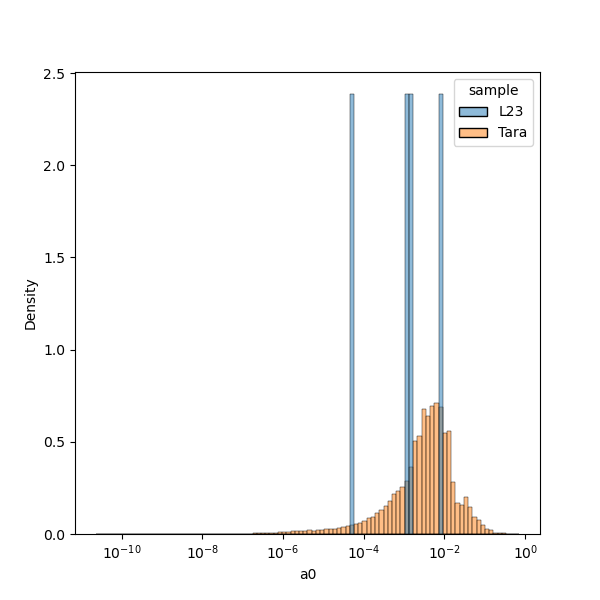

In [39]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

sns.histplot(df, x='a0', hue='sample', ax=ax, bins=100,
            common_bins=True, stat='density', common_norm=False,
            log_scale=True)

plt.show()


# Let's plot a few

In [10]:
list(d_tara.keys())

['M', 'coeff', 'spec', 'mask', 'err', 'wave', 'Rs']

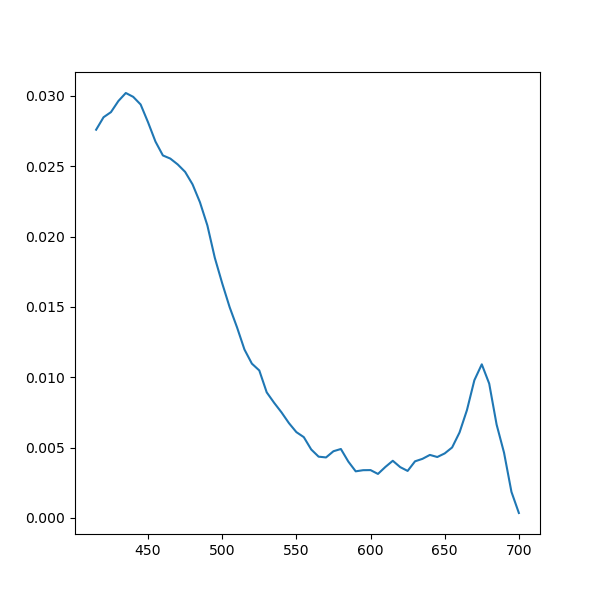

In [24]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

ax.plot(tara_wave, d_tara['spec'][0])
plt.show()

## $a(440)$

In [20]:
i_l23 = np.argmin(np.abs(wave-440.))
i_tara = np.argmin(np.abs(tara_wave-440.))

In [22]:
df2 = pandas.DataFrame()
df2['a440'] = d['spec'][:,i_l23].tolist() +  d_tara['spec'][:,i_tara].tolist() 
df2['sample'] = ['L23']*len(d['spec']) + ['Tara']*len(d_tara['spec'])

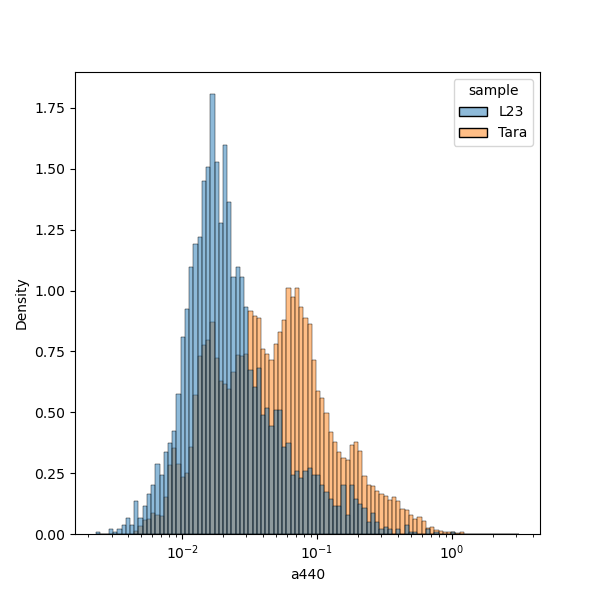

In [36]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

sns.histplot(df2, x='a440', hue='sample', ax=ax, bins=100,
            common_bins=True, stat='density', common_norm=False,
            log_scale=True)

plt.show()

# Fit a few

In [40]:
# Calculate Tara
wv_grid, final_tara, l23_a = iops.tara_matched_to_l23(
    low_cut=410.)
i0 = np.argmin(np.abs(wv_grid[0]-wave))
assert np.isclose(wv_grid[0], wave[i0])
i1 = np.argmin(np.abs(wv_grid[-1]-wave))

Loading Tara..


/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/tara/spectra.py:265: RuntimeWarning: invalid value encountered in divide
  isum = np.nansum(values[gd]*mask[gd], axis=0) / np.sum(mask[gd],axis=0)
/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/tara/spectra.py:266: RuntimeWarning: invalid value encountered in divide
  esum = np.nansum(err_vals[gd]*mask[gd], axis=0) / np.sum(mask[gd],axis=0)


In [41]:
final_tara.shape

(229335, 58)

In [63]:
cut_tara = final_tara[0:20000]

In [64]:
sig = 0.0005
V = np.ones_like(cut_tara) / sig**2
M_tara = M[:,i0:i1+1]
tara_NMF = nmf.NMF(cut_tara.T,
    V=V.T, W=M_tara.T, n_components=4)
tara_NMF.SolveNMF(H_only=True, verbose=True)

Current Chi2=6.4451, Previous Chi2=14641654.9455, Change=100.0000% @ niters=0
Current Chi2=3.6074, Previous Chi2=3.6931, Change=2.3214% @ niters=20
Current Chi2=2.3945, Previous Chi2=2.4394, Change=1.8416% @ niters=40
Current Chi2=1.7030, Previous Chi2=1.7298, Change=1.5498% @ niters=60
Current Chi2=1.2895, Previous Chi2=1.3055, Change=1.2237% @ niters=80
Current Chi2=1.0439, Previous Chi2=1.0534, Change=0.9002% @ niters=100
Current Chi2=0.8974, Previous Chi2=0.9031, Change=0.6314% @ niters=120
Current Chi2=0.8082, Previous Chi2=0.8117, Change=0.4346% @ niters=140
Current Chi2=0.7519, Previous Chi2=0.7542, Change=0.3011% @ niters=160
Current Chi2=0.7149, Previous Chi2=0.7165, Change=0.2135% @ niters=180
Current Chi2=0.6894, Previous Chi2=0.6905, Change=0.1562% @ niters=200
Current Chi2=0.6711, Previous Chi2=0.6719, Change=0.1178% @ niters=220
Current Chi2=0.6574, Previous Chi2=0.6580, Change=0.0913% @ niters=240
Current Chi2=0.6468, Previous Chi2=0.6473, Change=0.0725% @ niters=260
Cur

(0.5828376294486654, 0.3601781924565633)

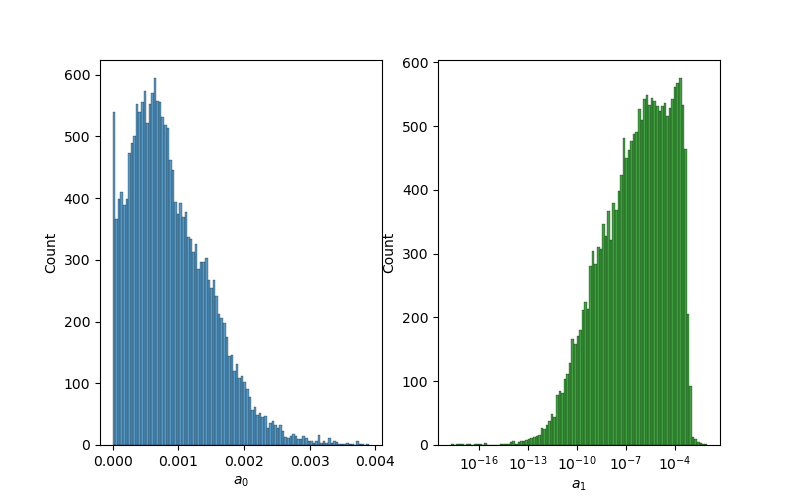

In [86]:
fig = plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

sns.histplot(x=tara_NMF.H[0,:], bins=100, ax=ax0)#, log_scale=True)
ax0.set_xlabel(r'$a_0$')
sns.histplot(x=tara_NMF.H[1,:], bins=100, ax=ax1, log_scale=True, color='g')
ax1.set_xlabel(r'$a_1$')

plt.show()

## Reconstruct

In [66]:
tara_recon = np.dot(tara_NMF.H.T, M_tara)
tara_recon.shape

(20000, 58)

## Plot

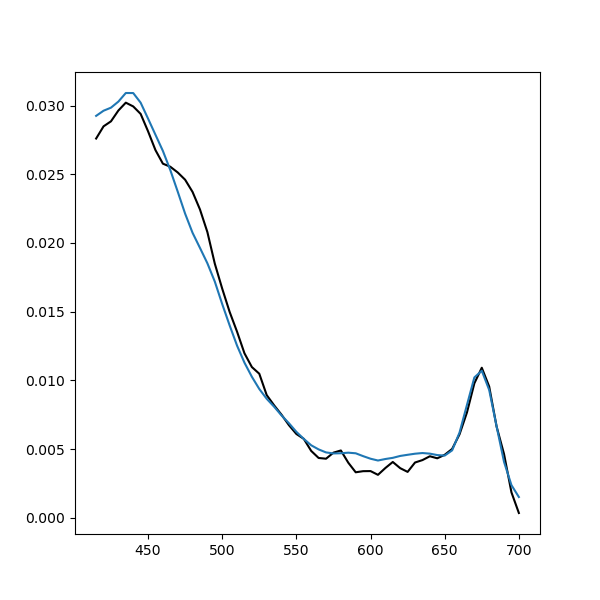

In [67]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

idx = 0
ax.plot(wv_grid, cut_tara[idx], 'k')
ax.plot(wv_grid, tara_recon[idx])


plt.show()

## Coeff

In [68]:
df3 = pandas.DataFrame()
df3['a0'] = tara_NMF.H[0,:]
df3['a1'] = tara_NMF.H[1,:]

In [74]:
#sns.displot(df3, x='a0', y='a1')#, kind='kde')

# Basis functions

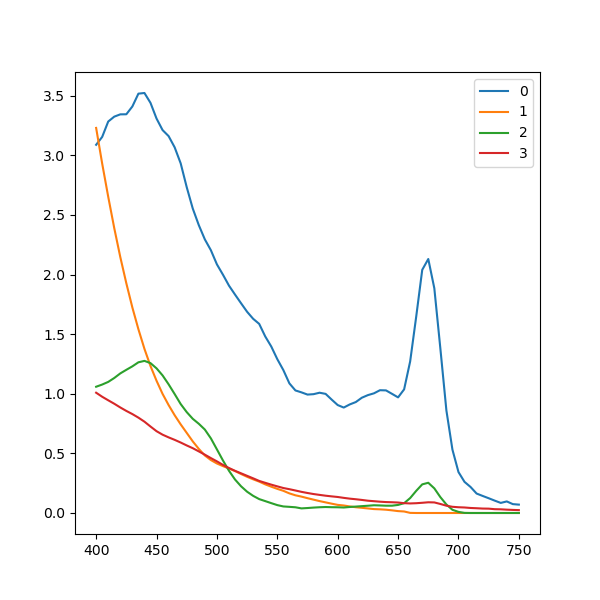

In [75]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

for ss in range(4):
    ax.plot(wave, M[ss], label=f'{ss}')

ax.legend()

plt.show()